# ArXiv Reinforcement Learning Papers Extraction
This notebook implements the paper extraction pipeline for the TEXTRA-AI project, focusing on RL papers from ArXiv

## 1. Setup and Imports

In [1]:
!pip install arxiv pytesseract pdf2image pandas tqdm

In [2]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run script server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [3]:
import arxiv
import os
import requests
import pandas as pd
from typing import List, Dict
import pytesseract
from pdf2image import convert_from_path
import numpy as np
from tqdm import tqdm
import logging
import time
from datetime import datetime
from pathlib import Path
logging.basicConfig(level=logging.INFO)

## 2. Project Directory Setup

In [4]:
project_root = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_root,"data")

dirs = {
'raw_pdfs': os.path.join(data_dir, "raw", "pdfs"),
'metadata': os.path.join(data_dir, "raw", "metadata"),
'processed_text': os.path.join(data_dir, "processed", "text"),
'vectors': os.path.join(data_dir, "processed", "vectors"),
'knowledge_base': os.path.join(data_dir, "knowledge_base")
}

for name, path in dirs.items():
    os.makedirs(path, exist_ok=True)
    print(f"✓ {name}: {path}")

✓ raw_pdfs: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\raw\pdfs
✓ metadata: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\raw\metadata
✓ processed_text: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\processed\text
✓ vectors: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\processed\vectors
✓ knowledge_base: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\knowledge_base


## 3.Paper Search Function

In [5]:
# Cell 1 - Test improved search
def search_papers(max_results: int = 10) -> List[arxiv.Result]:
    """Search for RL papers on ArXiv"""
    
    # Simplified query that will definitely return RL papers
    query = "reinforcement learning"
    
    print(f"Searching ArXiv for: {query}")
    
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate
    )
    
    try:
        results = list(search.results())
        print(f"Found {len(results)} papers")
        return results
    except Exception as e:
        print(f"Error during search: {e}")
        return []

# Try the search
results = search_papers(max_results=5)

# Verify results
if results:
    print("\nFound papers:")
    for i, paper in enumerate(results, 1):
        print(f"\n{i}. Title: {paper.title}")
        print(f"   Authors: {', '.join(author.name for author in paper.authors)}")
        print(f"   Published: {paper.published.strftime('%Y-%m-%d')}")
else:
    print("No results found. Please check your internet connection and try again.")

C:\Users\thinkpad\AppData\Local\Temp\ipykernel_17508\2352384537.py:17: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  results = list(search.results())
INFO:arxiv:Requesting page (first: True, try: 0): https://export.arxiv.org/api/query?search_query=reinforcement+learning&id_list=&sortBy=submittedDate&sortOrder=descending&start=0&max_results=100


Searching ArXiv for: reinforcement learning


INFO:arxiv:Got first page: 100 of 347227 total results


Found 5 papers

Found papers:

1. Title: Medical Adaptation of Large Language and Vision-Language Models: Are We Making Progress?
   Authors: Daniel P. Jeong, Saurabh Garg, Zachary C. Lipton, Michael Oberst
   Published: 2024-11-06

2. Title: Fed-EC: Bandwidth-Efficient Clustering-Based Federated Learning For Autonomous Visual Robot Navigation
   Authors: Shreya Gummadi, Mateus V. Gasparino, Deepak Vasisht, Girish Chowdhary
   Published: 2024-11-06

3. Title: Self-Consistency Preference Optimization
   Authors: Archiki Prasad, Weizhe Yuan, Richard Yuanzhe Pang, Jing Xu, Maryam Fazel-Zarandi, Mohit Bansal, Sainbayar Sukhbaatar, Jason Weston, Jane Yu
   Published: 2024-11-06

4. Title: Weighted Sobolev Approximation Rates for Neural Networks on Unbounded Domains
   Authors: Ahmed Abdeljawad, Thomas Dittrich
   Published: 2024-11-06

5. Title: A Comparative Study of Deep Reinforcement Learning for Crop Production Management
   Authors: Joseph Balderas, Dong Chen, Yanbo Huang, Li Wang, Ren

## 4.Examine Search Results

# Display basic information about found papers


In [6]:
# Display information about found papers and verify RL content
for paper in results:
    # Check if paper is RL-related
    is_rl = ('reinforcement learning' in paper.title.lower() or 
             'reinforcement learning' in paper.summary.lower())
    
    print(f"\nTitle: {paper.title}")
    print(f"Authors: {', '.join(author.name for author in paper.authors)}")
    print(f"Published: {paper.published.strftime('%Y-%m-%d')}")
    print(f"ArXiv ID: {paper.get_short_id()}")
    print(f"Categories: {', '.join(paper.categories)}")
    print(f"RL-related: {'Yes' if is_rl else 'No'}")
    print(f"\nAbstract snippet: {paper.summary[:200]}...")
    print("-" * 80)


Title: Medical Adaptation of Large Language and Vision-Language Models: Are We Making Progress?
Authors: Daniel P. Jeong, Saurabh Garg, Zachary C. Lipton, Michael Oberst
Published: 2024-11-06
ArXiv ID: 2411.04118v1
Categories: cs.CL, cs.AI, cs.LG
RL-related: No

Abstract snippet: Several recent works seek to develop foundation models specifically for
medical applications, adapting general-purpose large language models (LLMs) and
vision-language models (VLMs) via continued pret...
--------------------------------------------------------------------------------

Title: Fed-EC: Bandwidth-Efficient Clustering-Based Federated Learning For Autonomous Visual Robot Navigation
Authors: Shreya Gummadi, Mateus V. Gasparino, Deepak Vasisht, Girish Chowdhary
Published: 2024-11-06
ArXiv ID: 2411.04112v1
Categories: cs.RO, cs.AI, cs.CV, cs.DC
RL-related: No

Abstract snippet: Centralized learning requires data to be aggregated at a central server,
which poses significant challenges in terms of data 

## 5.Download Papers Function

In [7]:
def download_papers(results: List[arxiv.Result]) -> List[Dict]:
    """Download papers and save metadata"""
    metadata_list = []
    
    print(f"Downloading {len(results)} papers...")
    for paper in results:
        try:
            # Create metadata
            metadata = {
                'title': paper.title,
                'authors': [author.name for author in paper.authors],
                'published': paper.published.strftime('%Y-%m-%d'),
                'arxiv_id': paper.get_short_id(),
                'pdf_url': paper.pdf_url,
                'abstract': paper.summary,
                'categories': paper.categories
            }
            
            # Fix the PDF path construction
            pdf_filename = f"{paper.get_short_id()}.pdf"  # Just the filename
            pdf_path = os.path.join(dirs['raw_pdfs'], pdf_filename)  # Correct path joining
            
            if not os.path.exists(pdf_path):
                print(f"Downloading: {paper.title}")
                try:
                    # Download the PDF directly using requests
                    response = requests.get(paper.pdf_url)
                    response.raise_for_status()  # Check for download errors
                    
                    # Save the PDF
                    with open(pdf_path, 'wb') as f:
                        f.write(response.content)
                    print(f"Successfully downloaded to: {pdf_path}")
                    time.sleep(1)  # Be nice to ArXiv servers
                except Exception as download_error:
                    print(f"Download error for {paper.title}: {download_error}")
                    continue
            else:
                print(f"Already exists: {paper.title}")
            
            metadata['local_pdf_path'] = pdf_path
            metadata_list.append(metadata)
            
        except Exception as e:
            print(f"Error processing paper {paper.get_short_id()}: {str(e)}")
            continue
    
    print("Download complete!")
    return metadata_list

In [8]:
results = search_papers(max_results=5)
metadata_list = download_papers(results)

C:\Users\thinkpad\AppData\Local\Temp\ipykernel_17508\2352384537.py:17: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  results = list(search.results())
INFO:arxiv:Requesting page (first: True, try: 0): https://export.arxiv.org/api/query?search_query=reinforcement+learning&id_list=&sortBy=submittedDate&sortOrder=descending&start=0&max_results=100


Searching ArXiv for: reinforcement learning


INFO:arxiv:Got first page: 100 of 347227 total results


Found 5 papers
Downloading: Medical Adaptation of Large Language and Vision-Language Models: Are We Making Progress?
Successfully downloaded to: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\raw\pdfs\2411.04118v1.pdf
Downloading: Fed-EC: Bandwidth-Efficient Clustering-Based Federated Learning For Autonomous Visual Robot Navigation
Successfully downloaded to: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\raw\pdfs\2411.04112v1.pdf
Downloading: Self-Consistency Preference Optimization
Successfully downloaded to: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\raw\pdfs\2411.04109v1.pdf
Downloading: Weighted Sobolev Approximation Rates for Neural Networks on Unbounded Domains
Successfully downloaded to: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Research\data\raw\pdfs\2411.04108v1.pdf
Downloading: A Comparative Study of Deep Reinforcement Learning for Crop Production Management
Successfully downloaded to: c:\Users\thinkpad\Documents\GitHub\Textra_AI_Re

## 7.Save and Display Metadata

In [9]:
# Save metadata
if metadata_list:
    metadata_df = pd.DataFrame(metadata_list)
    metadata_path = os.path.join(dirs['metadata'], 'papers_metadata.csv')
    metadata_df.to_csv(metadata_path, index=False)
    
    print("\nMetadata Summary:")
    print(metadata_df.info())
    print("\nDownloaded papers:")
    print(metadata_df[['title', 'published', 'local_pdf_path']].to_string())


Metadata Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           5 non-null      object
 1   authors         5 non-null      object
 2   published       5 non-null      object
 3   arxiv_id        5 non-null      object
 4   pdf_url         5 non-null      object
 5   abstract        5 non-null      object
 6   categories      5 non-null      object
 7   local_pdf_path  5 non-null      object
dtypes: object(8)
memory usage: 448.0+ bytes
None

Downloaded papers:
                                                                                                    title   published                                                                        local_pdf_path
0                Medical Adaptation of Large Language and Vision-Language Models: Are We Making Progress?  2024-11-06  c:\Users\thinkpad\Documents\GitHub\Textra_AI_Res

## 11.Visualizations

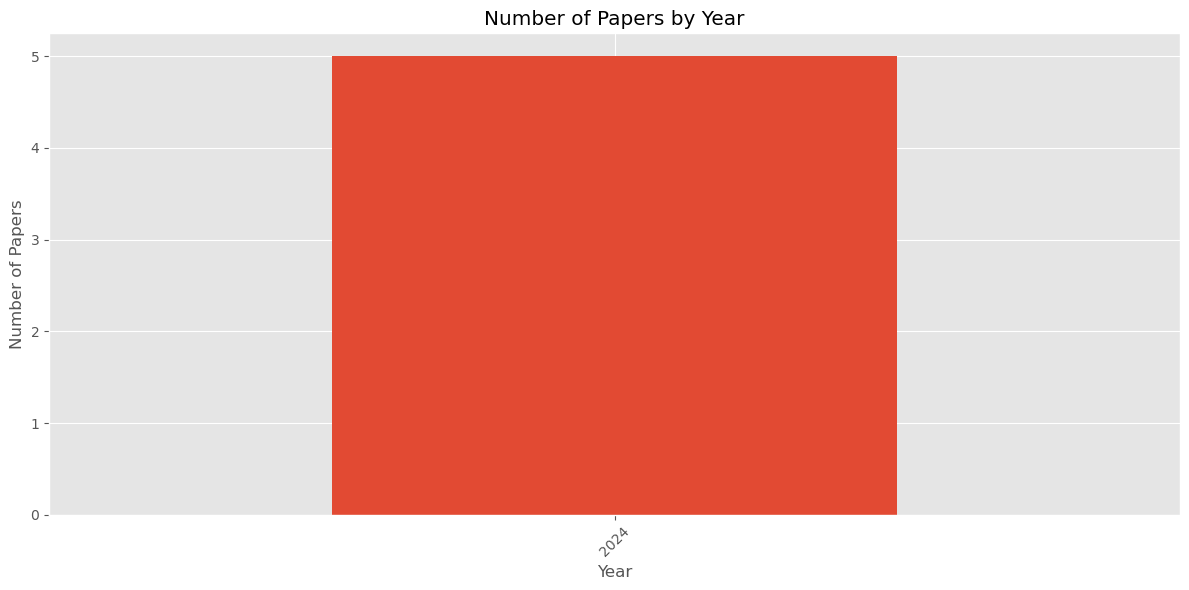

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
metadata_df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Papers by Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()